In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import torch

import pyciemss.visuals.plots as plots
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_petri_model,
    setup_petri_model,
    sample
)
from pyciemss.utils.interface_utils import convert_to_output_format
from pyciemss.utils import get_tspan

## Plot Calibration Data

,V
time,
0,3.424864e+13
1,7.482611e+13
2,1.107730e+14
3,1.455132e+14
4,1.789461e+14
...,...
72,3.208533e+16
73,3.321720e+16
74,3.499195e+16


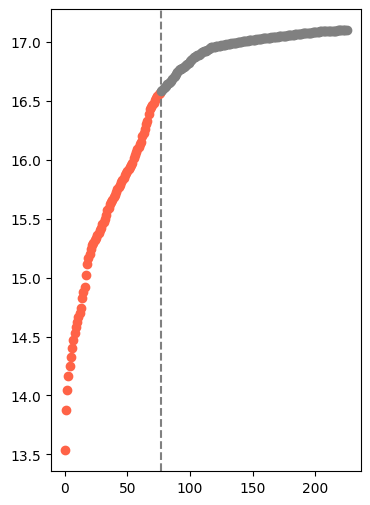

In [2]:
# Load Data
## This uses the cumsum() of the raw data
data_train = pd.read_csv('./data/processed_dataset_train.csv', index_col="time")
data_test  = pd.read_csv('./data/processed_dataset_test.csv', index_col="time")
display(data_train)

# Plot
plt.figure(figsize=(4,6))
plt.scatter(data_train.index, np.log10(data_train.V), color='tomato')
plt.scatter(data_test.index, np.log10(data_test.V), color='grey')
plt.axvline(77, linestyle='dashed', color='grey')

# # Change x-axis Ticks to Dates
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))

## Define Model

In [91]:
import sympy
import itertools
from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel

person_units = lambda: Unit(expression=sympy.Symbol('person'))
virus_units = lambda: Unit(expression=sympy.Symbol('virus'))
virus_per_gram_units = lambda: Unit(expression=sympy.Symbol('virus')/sympy.Symbol('gram'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
gram_units = lambda: Unit(expression=sympy.Symbol('gram'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

# See Table 1 of the paper
c = {
    'S': Concept(name='S', units=person_units(), identifiers={'ido': '0000514'}),
    'E': Concept(name='E', units=person_units(), identifiers={'apollosv': '0000154'}),
    'I': Concept(name='I', units=person_units(), identifiers={'ido': '0000511'}),
    'V': Concept(name='V', units=person_units(), identifiers={'vido': '0001331'}),
}


parameters = {
    'gamma': Parameter(name='gamma', value=0.08, units=per_day_units()),
    'delta': Parameter(name='delta', value=1/8, units=per_day_units()),
    'alpha': Parameter(name='alpha', value=500, units=gram_units(),
                       distribution=Distribution(type='Uniform1',
                                                 parameters={
                                                     'minimum': 51,
                                                     'maximum': 796
                                                 })),
    'lambda': Parameter(name='lambda', value=9.66e-8, units=per_day_per_person_units()),
    'beta': Parameter(name='beta', value=4.49e7, units=virus_per_gram_units()),
    'k': Parameter(name='k', value=1/3, units=per_day_units()),
}

initials = {
    'S': Initial(concept=Concept(name='S'), value=2_300_000),
    'E': Initial(concept=Concept(name='E'), value=1000),
    'I': Initial(concept=Concept(name='I'), value=0),
    'V': Initial(concept=Concept(name='V'), value=0),
}

S, E, I, V, gamma, delta, alpha, lmbd, beta, k = \
    sympy.symbols('S E I V gamma delta alpha lambda beta k')

t1 = ControlledConversion(subject=c['S'],
                          outcome=c['E'],
                          controller=c['I'],
                          rate_law=S*I*lmbd)
t2 = NaturalConversion(subject=c['E'],
                       outcome=c['I'],
                       rate_law=k*E)
t3 = NaturalDegradation(subject=c['I'],
                        rate_law=delta*I)
t4 = ControlledProduction(outcome=c['V'],
                          controller=c['I'],
                          rate_law=alpha*beta*(1-gamma)*I)
templates = [t1, t2, t3, t4]
observables = {}
tm = TemplateModel(
    templates=templates,
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='Scenario 3 base model'))

In [92]:
num_samples = 10
start_time = 0
end_time = 80 #226 # between 10/02/2020 and 01/25/2021
num_timepoints = (end_time-start_time)*10 + 1
timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

prior_samples = load_and_sample_petri_model(tm, num_samples, timepoints=timepoints, method="dopri5",
                                            visual_options={"title": "3_base", "subset":["I_sol", "E_sol", "V_sol"]}, 
                                            time_unit="days")
#display(prior_samples)

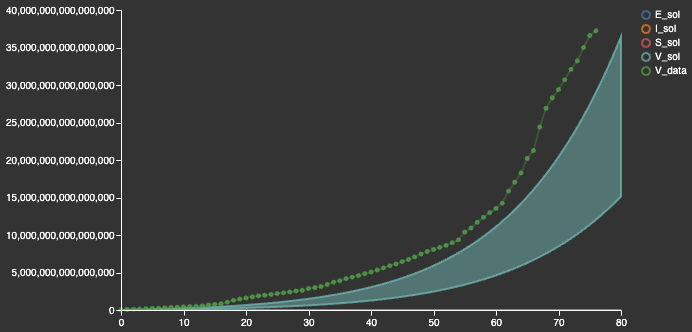

In [93]:
schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), subset=".*_sol",
                            points=data_train.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

## Calibration

In [94]:
post_samples = load_and_calibrate_and_sample_petri_model(
    tm,
    './data/processed_dataset_train.csv',
    num_samples,
    num_iterations=100,
    timepoints=timepoints,
    verbose=True,
    noise_scale=1.,
    method="euler", time_unit="days")

/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:848: UserWarning: Observation ObservationEvent(time=4.54803193861153e-06, observation={'V': tensor(3.4249e+13)}) is not in the range [0, 2301000.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:848: UserWarning: Observation ObservationEvent(time=1.0000070333480835, observation={'V': tensor(7.4826e+13)}) is not in the range [0, 2301000.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:848: UserWarning: Observation ObservationEvent(time=2.0000104904174805, observation={'V': tensor(1.1077e+14)}) is not in the range [0, 2301000.0]. This may be an error!
  warnings.warn(f"Observation {obs} is no

iteration 0: loss = 4.4308185546814915e+18
iteration 25: loss = 4.43081690541405e+18
iteration 50: loss = 4.430816355658236e+18
iteration 75: loss = 4.430816355658236e+18


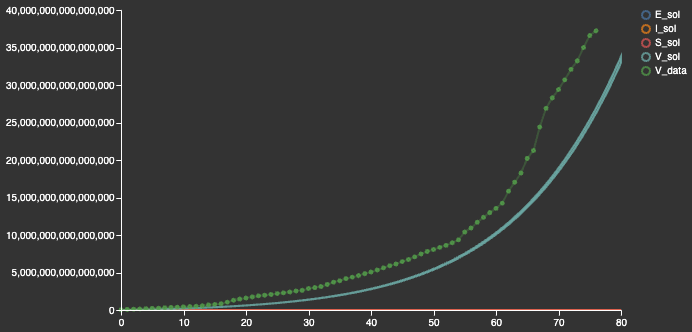

In [95]:
schema = plots.trajectories(pd.DataFrame(post_samples["data"]), subset=".*_sol",
                            points=data_train.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

## Now with Uncertainty over parameters

In [108]:
parameters = {
    'gamma': Parameter(name='gamma', value=0.08, units=per_day_units(),
                       distribution=Distribution(type='Uniform1',
                                                 parameters={
                                                     'minimum': 0.06,
                                                     'maximum': 0.09
                                                 })),
    'delta': Parameter(name='delta', value=1/8, units=per_day_units()),
    'alpha': Parameter(name='alpha', value=500, units=gram_units(),
                       distribution=Distribution(type='Uniform1',
                                                 parameters={
                                                     'minimum': 51,
                                                     'maximum': 796
                                                 })),
    'lambda': Parameter(name='lambda', value=9.66e-8, units=per_day_per_person_units(),
                       distribution=Distribution(type='Uniform1',
                                                 parameters={
                                                     'minimum': 6.66e-8,
                                                     'maximum': 12.66e-8
                                                 })),
    'beta': Parameter(name='beta', value=4.49e7, units=virus_per_gram_units()),
    'k': Parameter(name='k', value=1/3, units=per_day_units()),
}

# E here is E(0) -> (10, 100, 1000, 5000)
initials = {
    'S': Initial(concept=Concept(name='S'), value=2_300_000),
    'E': Initial(concept=Concept(name='E'), value=1000),
    'I': Initial(concept=Concept(name='I'), value=0),
    'V': Initial(concept=Concept(name='V'), value=0),
}

tm = TemplateModel(
    templates=templates,
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='Scenario 3 base model'))

In [109]:
num_samples = 10
start_time = 0
end_time = 80 #226 # between 10/02/2020 and 01/25/2021
num_timepoints = (end_time-start_time)*10 + 1
timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

prior_samples = load_and_sample_petri_model(tm, num_samples, timepoints=timepoints, method="dopri5",
                                            visual_options={"title": "3_base", "subset":["I_sol", "E_sol", "V_sol"]}, 
                                            time_unit="days")

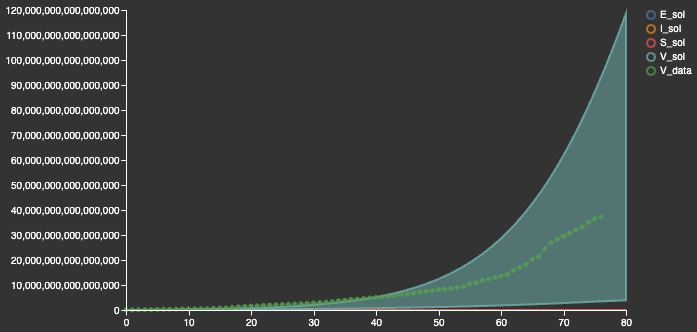

In [110]:
schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), subset=".*_sol",
                            points=data_train.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

## Calibration

In [111]:
post_samples = load_and_calibrate_and_sample_petri_model(
    tm,
    './data/processed_dataset_train.csv',
    num_samples,
    num_iterations=100,
    timepoints=timepoints,
    verbose=True,
    noise_scale=1.,
    method="euler", time_unit="days")

/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:848: UserWarning: Observation ObservationEvent(time=6.308041520242114e-06, observation={'V': tensor(3.4249e+13)}) is not in the range [0, 2301000.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:848: UserWarning: Observation ObservationEvent(time=1.000009298324585, observation={'V': tensor(7.4826e+13)}) is not in the range [0, 2301000.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:848: UserWarning: Observation ObservationEvent(time=2.000009059906006, observation={'V': tensor(1.1077e+14)}) is not in the range [0, 2301000.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not

iteration 0: loss = 4.430815805902422e+18
iteration 25: loss = 4.430815256146608e+18
iteration 50: loss = 4.430815256146608e+18
iteration 75: loss = 4.430815256146608e+18


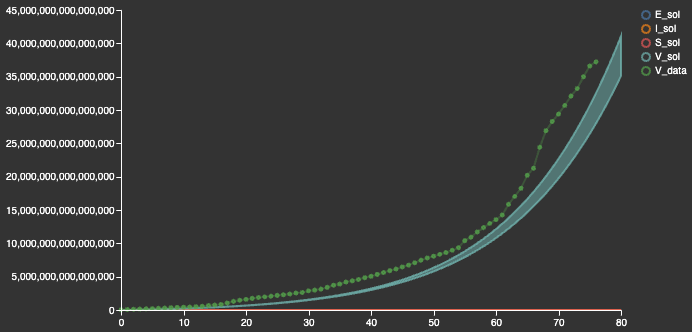

In [112]:
schema = plots.trajectories(pd.DataFrame(post_samples["data"]), subset=".*_sol",
                            points=data_train.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

## Use AMR

In [3]:
import urllib.request, json
import requests
from mira.sources.askenet.petrinet import model_from_url
from mira.metamodel import Distribution
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
from mira.modeling import Model

In [3]:
# From Vignesh
def change_model_parameters(filename, new_params):
    # new params = [(param, value), (param, value)]
    with open(filename, 'r') as f:
        model = json.load(f)
        # Change initial parameters
        for (param, value) in new_params:
            for idx in model["semantics"]["ode"]["parameters"]:
                if idx["id"] == param:
                    idx["value"] = value
    return model

In [4]:
#!pip install pygraphviz
#from mira.modeling.viz import GraphicalModel

SEIV_model_path = "data/eval_scenario3_base.json"
#real_url        = "https://github.com/indralab/mira/blob/hackathon2/notebooks/evaluation_2023.07/eval_scenario3_base.json"
SEIV_model_url = "https://raw.githubusercontent.com/indralab/mira/hackathon2/notebooks/evaluation_2023.07/eval_scenario3_base.json"
#SEIRV_model_url = "https://raw.githubusercontent.com/indralab/mira/hackathon/notebooks/evaluation_2023.07/eval_scenario3_base.json"

raw = model_from_url(SEIV_model_url)
raw.parameters['lambda'].value = 9.06e-8
#raw.parameters['lambda'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0, "maximum":2 * 9.06e-8})
raw.parameters['gamma'].value = 0.125
raw.parameters['beta'].value = 44852600
#raw.initials['E'].value = 1182
#raw.initials['V'].value = 1
print([(x, raw.parameters[x].value, raw.parameters[x].distribution) for x in raw.parameters])
print([(x, raw.initials[x].value) for x in raw.initials])

#GraphicalModel.for_jupyter(raw, width="20%")

[('lambda', 9.06e-08, None), ('k', 0.3333333333333333, None), ('delta', 0.125, None), ('alpha', 500.0, Distribution(type='Uniform1', parameters={'minimum': 51.0, 'maximum': 796.0})), ('beta', 44852600, None), ('gamma', 0.125, None)]
[('S', 2300000.0), ('I', 0.0), ('E', 1000.0), ('V', 0.0)]


In [5]:
Model(raw).variables

{('S', ('identity', 'ido:0000514')): <mira.modeling.Variable at 0x18a36c850>,
 ('I', ('identity', 'ido:0000511')): <mira.modeling.Variable at 0x18a9acdd0>,
 ('E',
  ('identity', 'apollosv:0000154')): <mira.modeling.Variable at 0x18a9adad0>,
 ('V', ('identity', 'vido:0001331')): <mira.modeling.Variable at 0x18a9aef50>}

In [6]:
num_samples = 10
start_time = 0
end_time = 80 #226 # between 10/02/2020 and 01/25/2021
num_timepoints = (end_time-start_time)*10 + 1
timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

prior_samples = load_and_sample_petri_model(raw, num_samples, timepoints=timepoints, time_unit="days")
display(prior_samples['data'].keys())

schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), subset=".*_sol",
                            points=data_train.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

Index(['timepoint_id', 'sample_id', 'alpha_param', 'lambda_param', 'k_param',
       'delta_param', 'beta_param', 'gamma_param', 'E_sol', 'I_sol', 'S_sol',
       'V_sol', 'timepoint_days'],
      dtype='object')

In [16]:
#AskeNetPetriNetModel(Model(raw)).to_json_file("SEIV_from_indralab.json", indent=2)

In [8]:
post_samples = load_and_calibrate_and_sample_petri_model(
    raw,
    './data/processed_dataset_train.csv',
    num_samples,
    num_iterations=100,
    timepoints=timepoints,
    verbose=True,
    noise_scale=1.,
    method="euler", time_unit="days")

/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:848: UserWarning: Observation ObservationEvent(time=1.0779837793961633e-05, observation={'V': tensor(3.4249e+13)}) is not in the range [0, 2301000.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:848: UserWarning: Observation ObservationEvent(time=1.0000073909759521, observation={'V': tensor(7.4826e+13)}) is not in the range [0, 2301000.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:848: UserWarning: Observation ObservationEvent(time=2.0000083446502686, observation={'V': tensor(1.1077e+14)}) is not in the range [0, 2301000.0]. This may be an error!
  warnings.warn(f"Observation {obs} is 

iteration 0: loss = 4.430814706390794e+18
iteration 25: loss = 4.430814706390794e+18
iteration 50: loss = 4.430814706390794e+18
iteration 75: loss = 4.430814706390794e+18


In [9]:
schema = plots.trajectories(pd.DataFrame(post_samples["data"]), subset=".*_sol",
                            points=data_train.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

## Create AMR

In [89]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
virus_units = lambda: Unit(expression=sympy.Symbol('virus'))
virus_per_gram_units = lambda: Unit(expression=sympy.Symbol('virus')/sympy.Symbol('gram'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
gram_units = lambda: Unit(expression=sympy.Symbol('gram'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

# See Table 1 of the paper
c = {
    'S': Concept(name='S', units=person_units(), identifiers={'ido': '0000514'}),
    'E': Concept(name='E', units=person_units(), identifiers={'apollosv': '0000154'}),
    'I': Concept(name='I', units=person_units(), identifiers={'ido': '0000511'}),
    'V': Concept(name='V', units=person_units(), identifiers={'vido': '0001331'}),
}


parameters = {
    'gamma': Parameter(name='gamma', value=0.08, units=per_day_units()),
    'delta': Parameter(name='delta', value=1/8, units=per_day_units()),
    'alpha': Parameter(name='alpha', value=500, units=gram_units(),
                       distribution=Distribution(type='Uniform1',
                                                 parameters={
                                                     'minimum': 51,
                                                     'maximum': 796
                                                 })),
    'lambda': Parameter(name='lambda', value=9.66e-8, units=per_day_per_person_units()),
    'beta': Parameter(name='beta', value=4.49e7, units=virus_per_gram_units()),
    'k': Parameter(name='k', value=1/3, units=per_day_units()),
}

initials = {
    'S': Initial(concept=Concept(name='S'), value=2_300_000),
    'E': Initial(concept=Concept(name='E'), value=1000),
    'I': Initial(concept=Concept(name='I'), value=0),
    'V': Initial(concept=Concept(name='V'), value=3.14e15),
}

S, E, I, V, gamma, delta, alpha, lmbd, beta, k = \
    sympy.symbols('S E I V gamma delta alpha lambda beta k')

t1 = ControlledConversion(subject=c['S'],
                          outcome=c['E'],
                          controller=c['I'],
                          rate_law=S*I*lmbd)
t2 = NaturalConversion(subject=c['E'],
                       outcome=c['I'],
                       rate_law=k*E)
t3 = NaturalDegradation(subject=c['I'],
                        rate_law=delta*I)
t4 = ControlledProduction(outcome=c['V'],
                          controller=c['I'],
                          rate_law=alpha*beta*(1-gamma)*I)
templates = [t1, t2, t3, t4]
observables = {}
tm = TemplateModel(
    templates=templates,
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='Scenario 3 base model'))

In [90]:
AskeNetPetriNetModel(Model(tm)).to_json_file("SEIV_handmade.json", indent=2)

## Ensemble